In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

import requests

from functions import *
from tqdm import tqdm


# API call

In [33]:
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

url = "https://ssd.jpl.nasa.gov/api/horizons.api"
format = "format=text"
command = "COMMAND=" # target body
targets = ["199", "299", "399", "499", "599", "699", "799", "899"]  # mercury, venus, earth, mars, jupiter, saturn, uranus, neptun
target_names = ["mercury", "venus", "earth", "mars", "jupiter", "saturn", "uranus", "neptun"]
obj_data = "OBJ_DATA='NO'"
ephemeris = "MAKE_EPHEM='YES'"
eph_type = "EPHEM_TYPE='VECTORS'"
vec_table = "VEC_TABLE='2'"
center = "CENTER='500@0'"
start = "START_TIME='1800-01-01'"
stop = "STOP_TIME='2000-01-01'"
step = "STEP_SIZE='1 d'"
cal_type = "CAL_TYPE=GREGORIAN"
vector_labels = "VEC_LABELS=NO"
csv_format = "CSV_FORMAT=YES"
units = "OUT_UNITS='AU-D'"
#quantities = "QUANTITIES='1,9,20,23,24,29'"

In [34]:
targets = targets[:2] + targets[3:4]
target_names = target_names[:2] + target_names[3:4]

In [35]:
data = []
time = []
for target in targets:
    path = url+"?"+format+"&"+command+target+"&"+obj_data+"&"+ephemeris+"&"+eph_type+"&"+vec_table+"&"+center+"&"+start+"&"+stop+"&"+step+"&"+cal_type+"&"+vector_labels+"&"+csv_format+"&"+units
    q, p, t = read_data(requests.get(path).text)
    data.append([[q], [p]])
    time.append([t])
    
data = np.asarray(data).reshape((len(targets),2,len(data[0][0][0]),3))
time = np.asarray(time).reshape((len(targets),len(time[0][0])))

In [36]:
print(data.shape)

(3, 2, 73049, 3)


## Data shape

9 x target body <br>
2 x vectors - q & p <br>
n x data points <br>
3 x coordinates - x, y, z

# Phase spaces for all bodies in the system

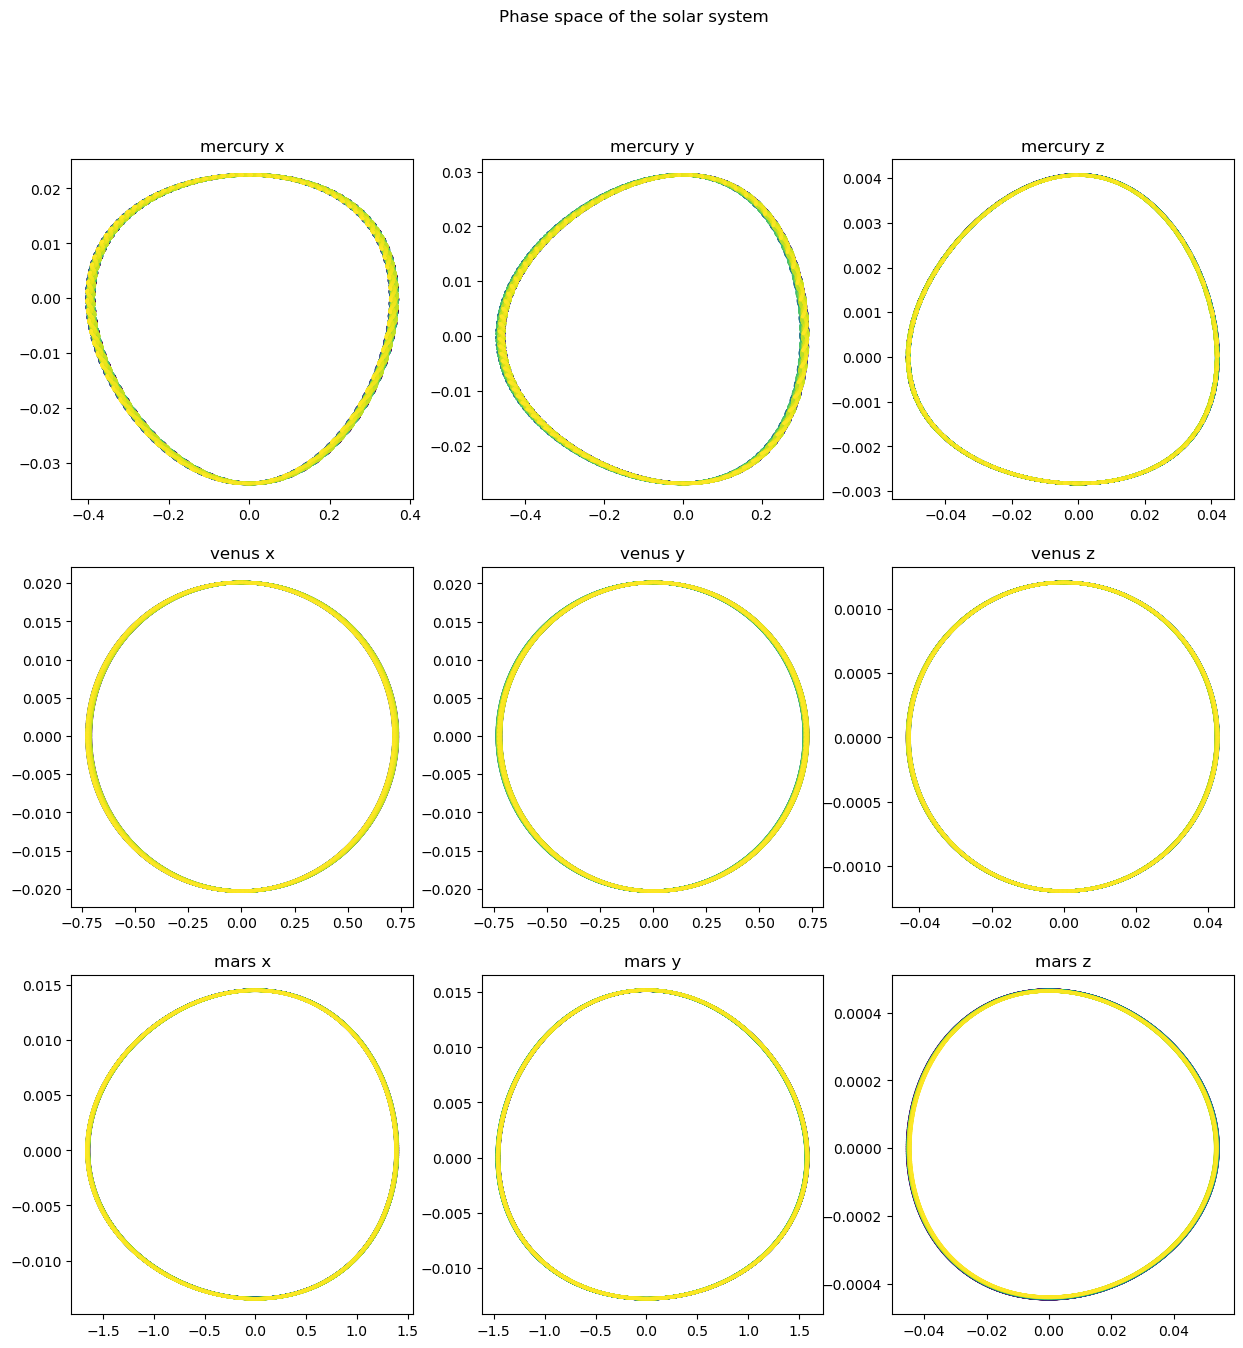

In [37]:
plot_phase_space(data, target_names, "Phase space of the solar system")

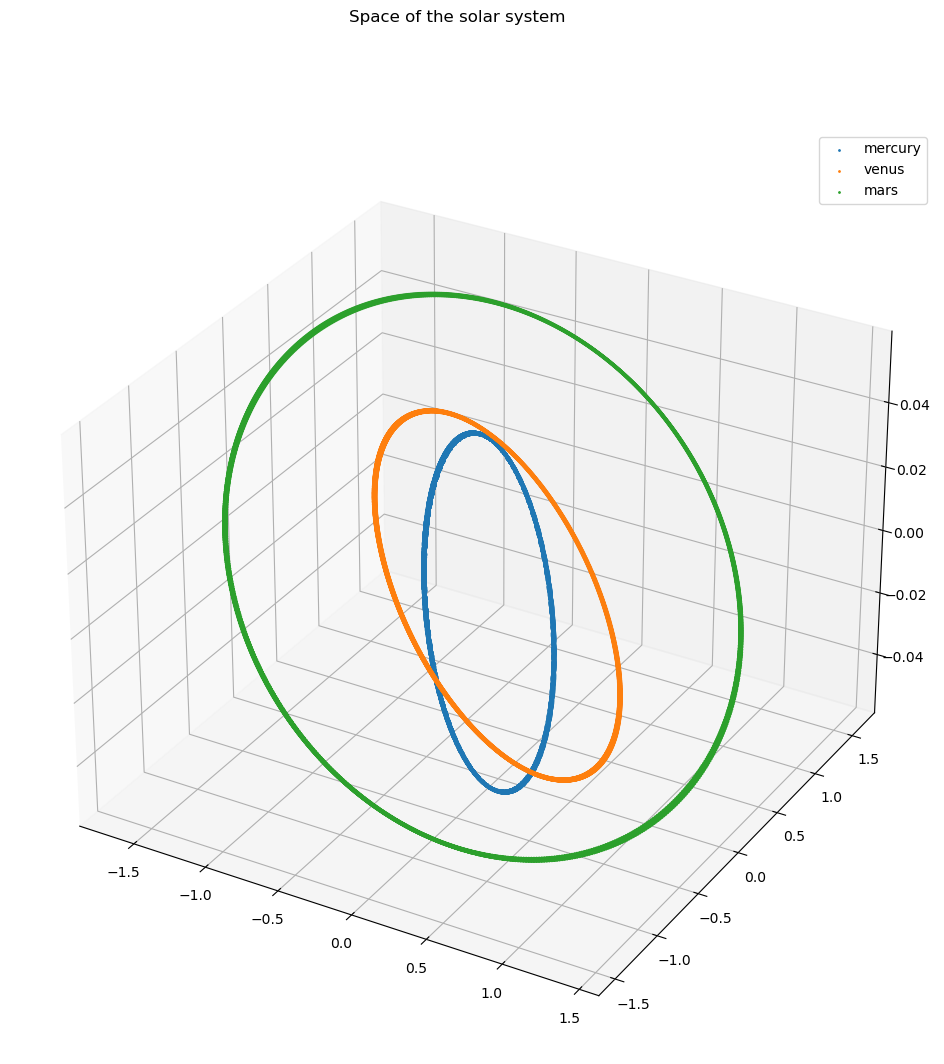

In [38]:
plot_space(data, target_names, "Space of the solar system")

# Learning the solar system

## Preparing the data

In [39]:
q, dq, p, dp, max_all = prep_data(data, time)

q_p = np.concatenate((q, p), axis=1)
q_p = torch.tensor(q_p, requires_grad=True, dtype=torch.float32)

dq_dp = np.concatenate((dq, dp), axis=1)
dq_dp = torch.tensor(dq_dp, requires_grad=True, dtype=torch.float32)

100%|██████████| 73048/73048 [02:01<00:00, 603.70it/s] 


In [40]:
#torch.save(q_p, "data/q_p.pt")
#torch.save(dq_dp, "data/dq_dp.pt")
#np.save("data/time.npy", time)
#np.save("data/data.npy", data)

## Normal Neural Network

In [41]:
class MLP(nn.Module):
    def __init__(self, bodys) -> None:
        super().__init__()

        self.fc1 = nn.Linear(bodys, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, bodys)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

## Hamiltonian

## Training loop

In [42]:
def train(model, x, dx, batch_size=32, epochs=100, baseline=True, lr=0.001):
    loss_hist = []
    ep_hist = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss(reduction="sum")

    for step in tqdm(range(epochs)):
        model.train()

        batches = np.random.choice(len(x), len(x))

        for batch in range(0, len(x)//batch_size+1):

            low = batch * batch_size
            high = min((batch + 1) * batch_size, len(x))
            bb = batches[low:high]

            x_batch = x[bb]
            dx_batch = dx[bb]

            optimizer.zero_grad()

            if baseline:
                pred = model(x_batch)
            else:   
                pred = HNN(x_batch, model)

            loss_val = loss(pred, dx_batch)
            loss_val.backward()
            optimizer.step()

        if step % (epochs/10) == 0:
            model.eval()
            if baseline:
                pred = model(x)
            else:   
                pred = HNN(x, model)

            loss_val = loss(pred, dx)
            loss_hist.append(loss_val.item())
            ep_hist.append(step+1)
            
            #print(f"Epoch {step}/{epochs} --- Train-Loss: {loss_val.item()}")#{round(loss_val.item(), 3)}")

    plt.plot(ep_hist, loss_hist)

# Baseline NN

In [43]:
model_baseline = MLP(q_p.shape[1])

train(model=model_baseline, x=q_p, dx=dq_dp, batch_size=64, epochs=50, baseline=True, lr=1e-3)


 12%|█▏        | 6/50 [16:04<1:57:53, 160.76s/it]


KeyboardInterrupt: 

In [ ]:

torch.save(model_baseline.state_dict(), "data/solar_system/model_baseline_small.pt")

# HNN

In [44]:
model_HNN = MLP(q_p.shape[1])

train(model=model_HNN, x=q_p, dx=dq_dp, batch_size=64, epochs=50, baseline=False, lr=1e-3)

torch.save(model_HNN.state_dict(), "data/solar_system/model_HNN_small.pt")

  6%|▌         | 3/50 [11:43<3:03:35, 234.37s/it]


KeyboardInterrupt: 

# Predicting

In [ ]:
q_p0 = q_p[0].detach().numpy()
t_span = [0, 1000]
steps = 2000

# integrate
t = torch.linspace(t_span[0], t_span[1], steps)
xHNN = integrate_model(model_HNN.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=False)
xBaseline = integrate_model(model_baseline.double(), t_span=t_span, y0=q_p0, t_eval=t, baseline=True)

In [ ]:
for i in range(len(max_all)):
    xHNN.y[i] *= max_all[i]
    xBaseline.y[i] *= max_all[i]

In [ ]:
# rescale output to original values

#xHNN.y[0:(len(targets)*3)] = (xHNN.y[0:(len(targets)*3)].T*max_q).T
#xHNN.y[(len(targets)*3):len(xHNN.y)] = (xHNN.y[(len(targets)*3):len(xHNN.y)].T*max_p).T

#xBaseline.y[0:(len(targets)*3)] = xBaseline.y[0:(len(targets)*3)]*max_q
#xBaseline.y[(len(targets)*3):len(xBaseline.y)] = xBaseline.y[(len(targets)*3):len(xBaseline.y)]*max_p

In [ ]:
HNN_data = reshape_data(xHNN.y)
Baseline_data = reshape_data(xBaseline.y)

# Plot the results
## HNN

In [ ]:
plot_phase_space(HNN_data, target_names, "Phase spaces for HNN")

In [ ]:
plot_space(HNN_data, target_names, "HNN", color=False)

## Baseline NN

In [ ]:
plot_phase_space(Baseline_data, target_names, "Phase spaces for Baseline")

In [ ]:
plot_space(Baseline_data, target_names, "Baseline")

In [ ]:
def plot_space2(data1, data2, target_names, title, color=False):
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ax = fig.add_subplot(projection='3d')

    for i in range(len(target_names)):
        ax.scatter(data1[i][0].T[0], data1[i][0].T[1], data1[i][0].T[2], s=1, label=target_names[i], c="red")
        ax.scatter(data2[i][0].T[0], data2[i][0].T[1], data2[i][0].T[2], s=1, label=target_names[i], c="blue")

    
    #ax.view_init(elev=0, roll=0, azim=300)
    fig.suptitle(title)
    plt.legend()
    plt.show()

In [ ]:
plot_space2(data, HNN_data, target_names, "HNN and real data")

In [ ]:
# save data
"""np.save("data/solar_system/data.npy", data)
np.save("data/solar_system/targets.npy", target_names)
np.save("data/solar_system/HNN_data.npy", HNN_data)
np.save("data/solar_system/Baseline_data.npy", Baseline_data)
np.save("data/solar_system/q_p0.npy", q_p0)"""

In [ ]:
np.save("data/solar_system/q_p0_small.npy", q_p0)